In [1]:
import sys
sys.path.insert(1, '../') 
from utils.loader import Loader
import tensorflow as tf
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten, Input
from tensorflow.keras import regularizers
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from transformers import TFBartForConditionalGeneration, BartTokenizer

# Descargar la lista de stopwords si no está ya descargada
nltk.download('stopwords')

# Cargar las stopwords en español
spanish_stopwords = set(stopwords.words('spanish'))

c:\Users\lingf\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lingf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train = Loader.load_train()

c:\Users\lingf\OneDrive\Escritorio\SRC\Cars_Price_Prediction-1\NLP\..\utils\loader.py:97: DtypeWarning: Columns (125,146) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
c:\Users\lingf\OneDrive\Escritorio\SRC\Cars_Price_Prediction-1\NLP\..\utils\loader.py:97: DtypeWarning: Columns (146) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
c:\Users\lingf\OneDrive\Escritorio\SRC\Cars_Price_Prediction-1\NLP\..\utils\loader.py:97: DtypeWarning: Columns (129,146) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
c:\Users\lingf\OneDrive\Escritorio\SRC\Cars_Price_Prediction-1\NLP\..\utils\loader.py:97: DtypeWarning: Columns (146) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
c:\Users\lingf\OneDrive\Escritorio\SRC\Cars_Price_Prediction-1\NLP\..\utils\loader.py:97: DtypeWarning: 

In [3]:
descriptions = [col for col in train.columns if "description" in col]

print(descriptions)

def custom_concat(row, cols):
    # Construir la descripción con lógica condicional basada en el valor de la celda
    parts = []
    for col_name in cols:  # Cambio para iterar solo sobre las columnas especificadas
        if col_name in row.index:  # Verificar que el nombre de la columna esté en el DataFrame
            value = row[col_name]
            if value == "no tiene" or not isinstance(value, str):
                parts.append(f"no tiene {col_name}")
            else:
                parts.append(str(value))  # Convertir a string para evitar problemas al unir
    # Unir todas las partes con espacios
    return ' '.join(parts)

# Aplicar la función al DataFrame
train['full_description'] = train.apply(custom_concat, axis=1, args=(descriptions,))
#train[descriptions].apply(lambda col: col.apply(lambda x: type(x).__name__).value_counts())

#descriptions.append("idx")
#descriptions.append("price")
#descriptions.append("km")

['motor_description', 'transmission_description', 'parking_sensors_description', 'Exterior_Llantas_description', 'Exterior_Molduras_description', 'Exterior_Neumáticos_description', 'Exterior_Puerta_description', 'Exterior_Retrovisor_description', 'Confort_Volante_description', 'seat_description', 'head_supporter_description']


In [4]:
filtered_columns = ["idx", "price", "km", "fuelType", "full_description"]
train = train[filtered_columns]
train["price_per_kilometer"] = train["price"]/train["km"]
train.dropna(inplace=True)
train

,idx,price,km,fuelType,full_description,price_per_kilometer
0,105953,-0.077067,-0.270171,Gasolina,"Motor de 1,3 litros ( 1.332 cc ) , cuatro cili...",0.285252
1,15683,-0.193101,0.313987,Diésel,"Motor de 2,0 litros ( 1.969 cc ) , cuatro cili...",-0.614996
2,153684,-0.308670,0.483472,Diésel,"Motor de 1,6 litros ( 1.560 cc ) , cuatro cili...",-0.638445
3,156928,-0.058037,-0.490595,Híbrido,"Motor de 1,8 litros ( 1.798 cc ) , cuatro cili...",0.118300
4,24443,-0.935252,2.164942,Diésel,"Motor de 1,9 litros ( 1.910 cc ) , 4 cilindros...",-0.431999
...,...,...,...,...,...,...
115592,19845,-0.058037,-0.163500,Diésel,"Motor de 1,6 litros ( 1.598 cc ) , cuatro cili...",0.354967
115593,102652,-0.889071,0.802049,Gasolina,"Motor de 2,0 litros ( 1.997 cc ) , 4 cilindros...",-1.108500
115594,101658,-0.309134,0.461325,Gas natural (CNG),"Motor de 1,4 litros ( 1.395 cc ) , cuatro cili...",-0.670101
115595,69350,-0.199598,0.735851,Diésel,"Motor de 2,2 litros ( 2.191 cc ) , cuatro cili...",-0.271249


In [5]:
#Parameters
verb_size = 200

In [6]:
def preprocess_text(text):
    # Convertir a minúsculas y eliminar caracteres especiales (pero mantener los números)
    text = text.lower()
    text = re.sub(r'[^\w\s\d]', '', text)  # Eliminar signos de puntuación, pero mantener números
    tokens = text.split()
    
    # Filtrar tokens, eliminando las stopwords
    filtered_tokens = [token for token in tokens if token not in spanish_stopwords]
    
    return filtered_tokens

train['tokens'] = train['full_description'].apply(preprocess_text)
model_w2v = Word2Vec(sentences=train['tokens'], vector_size=verb_size, window=1, min_count=3, workers=8)
word_vectors = model_w2v.wv

def get_average_embedding(tokens, model):
    embeddings = [model[word] for word in tokens if word in model]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.vector_size) 
train['embedding'] = train['tokens'].apply(lambda x: get_average_embedding(x, word_vectors))

In [7]:
train_df, test_df = train_test_split(train, test_size=0.2, random_state=42, stratify=train['fuelType'])
train_df.head()

,idx,price,km,fuelType,full_description,price_per_kilometer,tokens,embedding
2242,92306,-0.475759,-0.715314,Híbrido,"Motor de 1,0 litros ( 999 cc ) , tres cilindro...",0.665105,"[motor, 10, litros, 999, cc, tres, cilindros, ...","[-0.16160361, -0.10009166, -0.32464033, 0.2198..."
27893,87882,-0.877236,1.434820,Diésel,"Motor de 2 litros ( 1.991 cc ) , 4 cilindros e...",-0.611391,"[motor, 2, litros, 1991, cc, 4, cilindros, lín...","[-0.24790601, -0.07314416, -0.40247717, 0.2772..."
87329,83668,0.405634,-0.924968,Híbrido enchufable,"Motor de 2,5 litros ( 2.488 cc ) , cuatro cili...",-0.438538,"[motor, 25, litros, 2488, cc, cuatro, cilindro...","[-0.19034052, -0.012140048, -0.25362855, 0.353..."
37341,79319,0.498925,-0.180877,Diésel,"Motor de 2,0 litros ( 1.995 cc ) , cuatro cili...",-2.758359,"[motor, 20, litros, 1995, cc, cuatro, cilindro...","[-0.07045267, -0.051588427, -0.22068815, 0.206..."
83683,89910,-0.240906,-0.126775,Híbrido enchufable,"Motor de 1,6 litros ( 1.580 cc ) , cuatro cili...",1.900263,"[motor, 16, litros, 1580, cc, cuatro, cilindro...","[-0.17331654, -0.014630872, -0.30179378, 0.264..."


In [12]:
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')
bart_model = TFBartForConditionalGeneration.from_pretrained('facebook/bart-large')

# Tokenizar la columna 'full description'
tokens = tokenizer(train['full_description'].tolist(), return_tensors='tf', max_length=512, truncation=True, padding='max_length')

# Extraer los input_ids que son necesarios para el modelo
input_ids = tokens['input_ids']

# Si estás utilizando los embeddings directamente, puedes seguir este paso
# De lo contrario, si necesitas procesar los embeddings, asegúrate de que estén en formato adecuado antes de continuar
tensor_embeddings = tf.convert_to_tensor(train['embedding'], dtype=tf.float32)

# Compilar el modelo con la configuración deseada
bart_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# Entrenar el modelo
bart_model.fit(x=input_ids, y=tensor_embeddings, epochs=3, batch_size=8)

All model checkpoint layers were used when initializing TFBartForConditionalGeneration.

All the layers of TFBartForConditionalGeneration were initialized from the model checkpoint at facebook/bart-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.


KeyError: 'full description'

In [48]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=100, input_shape=[verb_size],
                          kernel_regularizer=regularizers.l2(0.001)
                          ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=64 , activation='relu',
                          kernel_regularizer=regularizers.l2(0.001)
                          ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=32, activation='relu',
                          kernel_regularizer=regularizers.l2(0.001)
                          ),
    tf.keras.layers.Dense(units=1, activation='softplus')
    ])#output

def custom_loss(y_true, y_pred):
    # Penalizar mas los valores negativos
    loss = tf.where(y_pred < 0, tf.square(y_pred - y_true) * 10, tf.square(y_pred - y_true))
    return tf.reduce_mean(loss)

model.compile(
    optimizer = tf.keras.optimizers.Adam(0.01),
    loss = custom_loss
)

c:\Users\lingf\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [49]:
x = np.stack(train_df["embedding"].values)
y = train_df['price'].to_numpy()

scaler_x = StandardScaler()
x_scaled = scaler_x.fit_transform(x)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

In [50]:
print("COMIENZA EL ENTRENAMIENTO...")
historial = model.fit(x_scaled, y_scaled, epochs=30, batch_size = 32, verbose=True)
print("TERMINA EL ENTRENAMIENTO...")

COMIENZA EL ENTRENAMIENTO...
Epoch 1/30
2760/2760 ━━━━━━━━━━━━━━━━━━━━ 3s 682us/step - loss: 0.9117
Epoch 2/30
2760/2760 ━━━━━━━━━━━━━━━━━━━━ 2s 686us/step - loss: 0.5797
Epoch 3/30
2760/2760 ━━━━━━━━━━━━━━━━━━━━ 2s 692us/step - loss: 0.5451
Epoch 4/30
2760/2760 ━━━━━━━━━━━━━━━━━━━━ 2s 705us/step - loss: 0.4999
Epoch 5/30
2760/2760 ━━━━━━━━━━━━━━━━━━━━ 2s 683us/step - loss: 0.5146
Epoch 6/30
2760/2760 ━━━━━━━━━━━━━━━━━━━━ 2s 689us/step - loss: 0.5320
Epoch 7/30
2760/2760 ━━━━━━━━━━━━━━━━━━━━ 2s 712us/step - loss: 0.5370
Epoch 8/30
2760/2760 ━━━━━━━━━━━━━━━━━━━━ 2s 682us/step - loss: 0.5628
Epoch 9/30
2760/2760 ━━━━━━━━━━━━━━━━━━━━ 2s 692us/step - loss: 0.5087
Epoch 10/30
2760/2760 ━━━━━━━━━━━━━━━━━━━━ 2s 678us/step - loss: 0.5332
Epoch 11/30
2760/2760 ━━━━━━━━━━━━━━━━━━━━ 2s 674us/step - loss: 0.5645
Epoch 12/30
2760/2760 ━━━━━━━━━━━━━━━━━━━━ 2s 677us/step - loss: 0.5144
Epoch 13/30
2760/2760 ━━━━━━━━━━━━━━━━━━━━ 2s 681us/step - loss: 0.5174
Epoch 14/30
2760/2760 ━━━━━━━━━━━━━━━━━━━━ 2

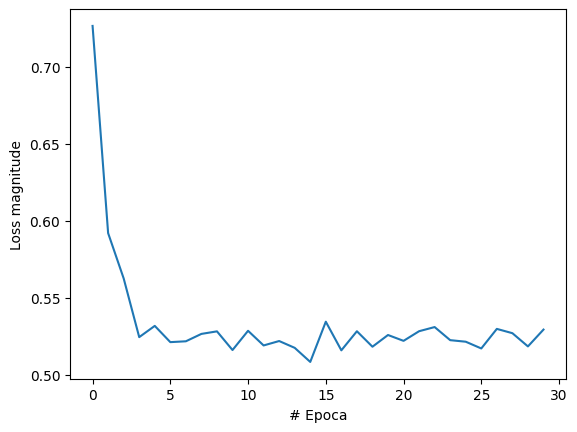

In [51]:
plt.xlabel("# Epoca")
plt.ylabel("Loss magnitude")
plt.plot(historial.history["loss"])

In [52]:
prediction = scaler_y.inverse_transform(model.predict(np.stack(test_df["embedding"].values))).flatten()
realPrice = test_df['price'].to_numpy()

690/690 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step


In [53]:
result = pd.DataFrame({'Prediction': prediction, 'Real price': realPrice})

diff = np.mean(abs( (realPrice - prediction)/realPrice ))
print(result)
print("Hay un MAPE de " + str(diff) + "%")
plt.show()

         Prediction  Real price
0      23580.343750       46900
1      23574.466797       29999
2      23562.980469       20795
3      23574.101562       24460
4      23566.652344       21900
...             ...         ...
22074  23563.353516       14462
22075  23570.429688       26490
22076  23568.244141       22900
22077  23581.535156       47900
22078  23578.197266       42920

[22079 rows x 2 columns]
Hay un MAPE de 0.8218998834012647%
